# Assignment 04

In [1]:
import os
import sys
# add directory to import from
sys.path.insert(0, "../utils")
import shutil
import utils
import numpy as np
import random
import importlib
importlib.reload(utils)
import prepare_human_action_data
importlib.reload(prepare_human_action_data)
import network_samples
import train_eval
importlib.reload(train_eval)
import time
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F

In [2]:
utils.set_random_seed()

#### **Task 2**
 1. Perform "Action Recognition" on the KTH-Actions dataset:
    - https://www.csc.kth.se/cvap/actions/
    - https://github.com/tejaskhot/KTH-Dataset
    - Use spatial dimensionality of frames of 64x64
    - Split videos into subsequences of e.g. 20 frames. Treat each of these subsequences as independent.

To prepare the dataset, download the data from the above links, unzip into Session04/data/videos and run the lower code. Installation of ffmpeg needed.

In [3]:
%%capture
# one time usage when data is unzipped into data/videos
#prepare_human_action_data.prepare_human_action_data()

In [4]:
resize  = T.Resize((64, 64))
seq_size = 20

train_dataset = prepare_human_action_data.HumanActionDataset(
    sequence_length=seq_size, train=True, transform=resize
    )
test_dataset = prepare_human_action_data.HumanActionDataset(
    sequence_length=seq_size, train=False, transform=resize
    )
print("Length train set: ", len(train_dataset))
print("Length test set: ", len(test_dataset))

Length train set:  9120
Length test set:  4984


In [5]:
### Setting up "constants", num Labels for layer sizes, and network outputs
NUM_LABELS = len(train_dataset.action_labels)
BATCH_SIZE = 64
LR = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 25

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

2. Implement a model with the following structure:
    - Convolutional encoder
    - Recurrent module
    - Classifier (probably Conv + AvgPooling/Flattening + Linear)

In [7]:
class SimpleRNN(nn.Module):

    def __init__(self, input_dim, conv_feature_maps, hidden_dim, n_layers, num_classes, activation="tanh") -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps
        input_channel, height, width = input_dim
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."
        assert (activation == "tanh" or activation == "relu"), "Activation function can only be either tanh or relu"

        # with maxpool input shape is divided by 2 
        self.encoder = nn.Sequential(
            network_samples.ConvBlock(input_channel, conv_feature_maps[0], kernel_size=3, pool=True, batchNorm=True),
            network_samples.ConvBlock(conv_feature_maps[0], conv_feature_maps[1], kernel_size=3, pool=True, batchNorm=True)
        )

        # compute new input dim
        new_input_dim = int(height//4 * width//4 * conv_feature_maps[1])

        # RNN layer
        self.rnn = nn.RNN(new_input_dim, hidden_dim, n_layers, batch_first=True, nonlinearity=activation)

        # changed from taking only the last layer as input for the fc to all layers and outputs, seems to work better
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        batch_size, time_seq, height, width = x.shape

        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for rnn with B x T_seq x all
        x = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps[1] * height//4 * width//4)
 
        # init hidden state with zeros, shape: num_layers, batch size, hidden dimension
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        # input x and hidden state to rnn
        out, hidden = self.rnn(x, h_0)

        # only take last rnn output
        out = self.fc(out[:, -1, :])

        return out

In [8]:
input_dim = [1, 64, 64]
conv_feature_maps = [16, 16]
hidden_dim_rnn = 128
n_layers = 8
rnn_model = SimpleRNN(
    input_dim=input_dim, conv_feature_maps=conv_feature_maps, hidden_dim=hidden_dim_rnn, 
    n_layers=n_layers, num_classes=NUM_LABELS
    )
criterion = nn.CrossEntropyLoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=LR)
rnn_scheduler = torch.optim.lr_scheduler.StepLR(rnn_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(rnn_model)

775414

In [11]:
importlib.reload(train_eval)

rnn_model = rnn_model.to(DEVICE)
rnn_tboard = utils.make_tboard_logs("simple_rnn_testing")
rnn_train_loss, rnn_val_loss, rnn_loss_iters, rnn_valid_acc, rnn_conf_matx = train_eval.train_model(
    model=rnn_model, optimizer=rnn_optimizer, scheduler=rnn_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=rnn_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session04/tboard_logs/simple_rnn_testing


Epoch 25 Iter 142: mean loss 0.49027. : 100%|██████████| 142/142 [00:07<00:00, 19.11it/s]

Training completed after 3.79min


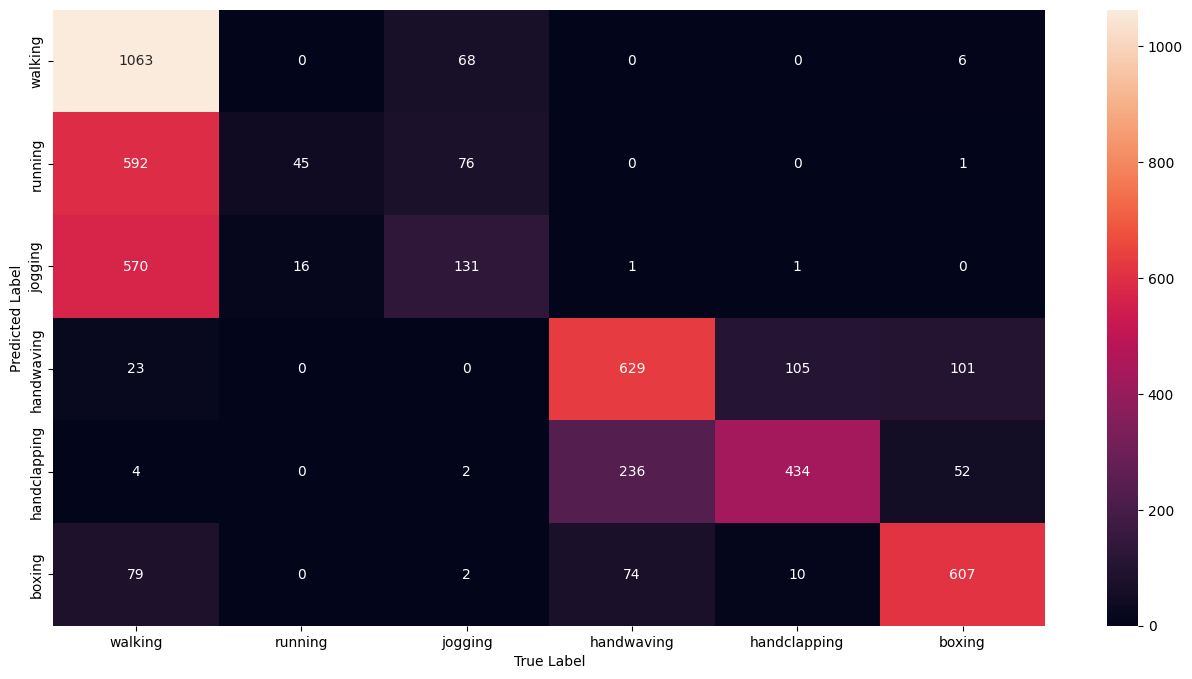

In [12]:
importlib.reload(utils)
utils.plot_confusion(rnn_conf_matx, train_dataset.action_labels)

3. Train, evaluate, and compare the model with the following recurrent modules:
    - PyTorch LSTM model (using nn.LSTMCell)
    - PyTorch GRU model (using nn.GRUCell)
    - Your own ConvLSTM
    - **Note**: Different recurrent modules (e.g. LSTM vs ConvLSTM) might require slight changes in the encoder and classifier

In [13]:
class LSTMModel(nn.Module):

    def __init__(self, input_dim, conv_feature_maps, hidden_dim, n_layers, num_classes, device) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps
        input_channel, height, width = input_dim
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."

        # with maxpool input shape is divided by 2 
        self.encoder = nn.Sequential(
            network_samples.ConvBlock(input_channel, conv_feature_maps[0], kernel_size=3, pool=True, batchNorm=True),
            network_samples.ConvBlock(conv_feature_maps[0], conv_feature_maps[1], kernel_size=3, pool=True, batchNorm=True)
        )

        # compute new input dim
        new_input_dim = int(height//4 * width//4 * conv_feature_maps[1])

        # LSTM layer
        self.LSTM = nn.LSTM(input_size=new_input_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

        # changed from taking only the last layer as input for the fc to all layers and outputs, seems to work better
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        batch_size, time_seq, height, width = x.shape

        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for LSTM with B x T_seq x all
        x = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps[1] * height//4 * width//4)
 
        # init hidden state with zeros, shape: num_layers, batch size, hidden dimension
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        # input x and hidden state to LSTM
        out, (h_0, c_0) = self.LSTM(x, (h_0, c_0))

        # only take last LSTM output
        out = self.fc(out[:, -1, :])

        return out

In [14]:
input_dim = [1, 64, 64]
conv_feature_maps = [16, 16]
hidden_dim_lstm = 128
n_layers = 8
lstm_model = LSTMModel(
    input_dim=input_dim, conv_feature_maps=conv_feature_maps, hidden_dim=hidden_dim_lstm, 
    n_layers=n_layers, num_classes=NUM_LABELS, device=DEVICE
    )
criterion = nn.CrossEntropyLoss()
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR)
lstm_scheduler = torch.optim.lr_scheduler.StepLR(lstm_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(lstm_model)

3091702

In [15]:
importlib.reload(train_eval)

lstm_model = lstm_model.to(DEVICE)
lstm_tboard = utils.make_tboard_logs("simple_lstm")
lstm_train_loss, lstm_val_loss, lstm_loss_iters, lstm_valid_acc, lstm_conf_matx = train_eval.train_model(
    model=lstm_model, optimizer=lstm_optimizer, scheduler=lstm_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=lstm_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session04/tboard_logs/simple_lstm


Epoch 25 Iter 142: mean loss 0.31356. : 100%|██████████| 142/142 [00:07<00:00, 19.08it/s]

Training completed after 3.92min


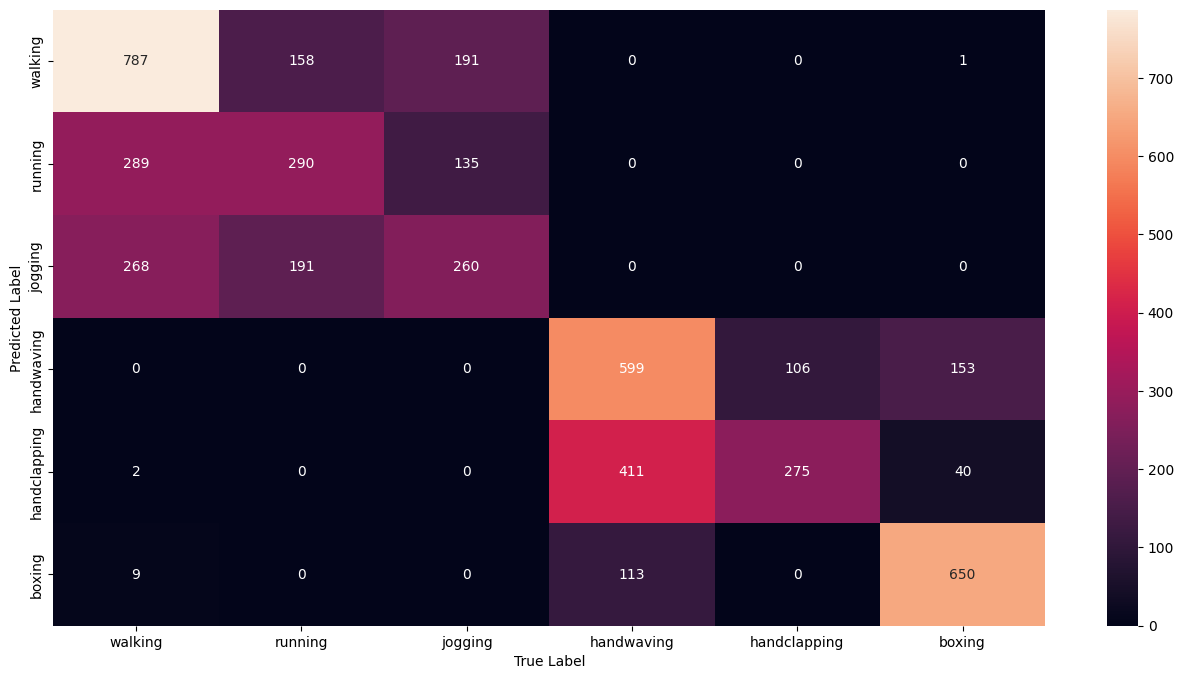

In [16]:
importlib.reload(utils)
utils.plot_confusion(lstm_conf_matx, train_dataset.action_labels)

In [17]:
class GRUModel(nn.Module):

    def __init__(self, input_dim, conv_feature_maps, hidden_dim, n_layers, num_classes, device) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps
        input_channel, height, width = input_dim
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."

        # with maxpool input shape is divided by 2 
        self.encoder = nn.Sequential(
            network_samples.ConvBlock(input_channel, conv_feature_maps[0], kernel_size=3, pool=True, batchNorm=True),
            network_samples.ConvBlock(conv_feature_maps[0], conv_feature_maps[1], kernel_size=3, pool=True, batchNorm=True)
        )

        # compute new input dim
        new_input_dim = int(height//4 * width//4 * conv_feature_maps[1])

        # GRU layer
        self.GRU = nn.GRU(input_size=new_input_dim, hidden_size=hidden_dim, num_layers=n_layers, batch_first=True)

        # changed from taking only the last layer as input for the fc to all layers and outputs, seems to work better
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        batch_size, time_seq, height, width = x.shape

        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for GRU with B x T_seq x all
        x = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps[1] * height//4 * width//4)
 
        # init hidden state with zeros, shape: num_layers, batch size, hidden dimension
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(x.device)
        # input x and hidden state to GRU
        out, h_0 = self.GRU(x, h_0)

        # only take last GRU output
        out = self.fc(out[:, -1, :])

        return out

In [18]:
input_dim = [1, 64, 64]
conv_feature_maps = [16, 16]
hidden_dim_gru = 128
n_layers = 8
gru_model = GRUModel(
    input_dim=input_dim, conv_feature_maps=conv_feature_maps, hidden_dim=hidden_dim_gru, 
    n_layers=n_layers, num_classes=NUM_LABELS, device=DEVICE
    )
criterion = nn.CrossEntropyLoss()
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=LR)
gru_scheduler = torch.optim.lr_scheduler.StepLR(gru_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(gru_model)

2319606

In [19]:
importlib.reload(train_eval)

gru_model = gru_model.to(DEVICE)
gru_tboard = utils.make_tboard_logs("simple_gru")
gru_train_loss, gru_val_loss, gru_loss_iters, gru_valid_acc, gru_conf_matx = train_eval.train_model(
    model=gru_model, optimizer=gru_optimizer, scheduler=gru_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=gru_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session04/tboard_logs/simple_gru


Epoch 25 Iter 142: mean loss 0.30708. : 100%|██████████| 142/142 [00:07<00:00, 19.10it/s]

Training completed after 3.86min


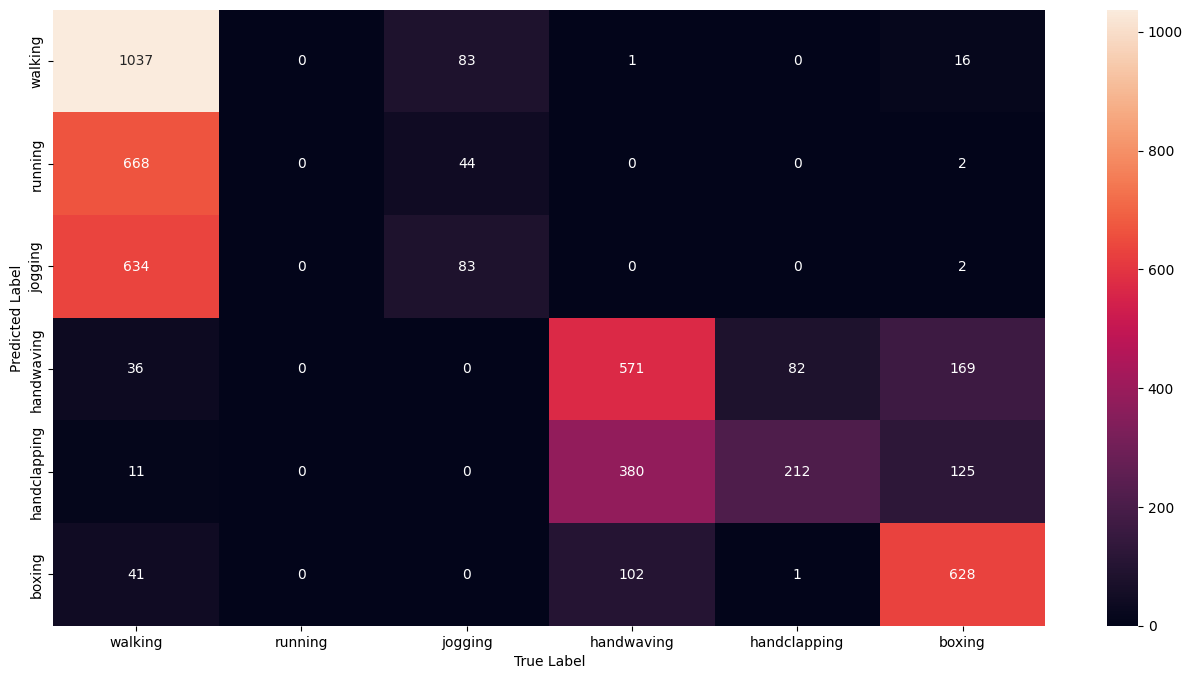

In [21]:
importlib.reload(utils)
utils.plot_confusion(gru_conf_matx, train_dataset.action_labels)

### Notes and results of task 2

Initially we tried running the simpleRNN model, that is using nn.RNN, and we were using an encoder with a single ConvBlock with pooling. When using this model without batchnorm, with ReLU as the non-linearity, and with 12 number of hidden layers for the RNN itself, we obtained an accuracy of about 60%, nevertheless since the other models implemented directly by Pytorch use only tanh as the non-linearity function, we decided to include batchnorm in our Convolution Block for the encoder, and also tanh as the activation function. With this, and a number of layers of 8 for the RNN, we ended up obtaining an accuray of 59%, thus the overfitting is still clearly visible.

On the other hand we expected a better result with our LSTM model, since it has a forget rate, and therefore discards "useless" data. We used the same hyperparams, the same encoder and classifier architecture, and the obtained accuracy after the same 25 epochs was of 58%, which is very similar to what we obtained with the simple RNN before, and even a little lower.

At last, for the GRU model, again using the same hyperparameters, and same encoder and classifier architecture, we obtain a final accuracy of 64.2%, which shows some improvement in comparison to the previous models.

Nevertheless, based on the validation set loss, we can observe that we are overfitting in all of the models, leading us to know that a way more detailed tuning of the model is essential and required, and that the RNNs might not be the more appropiate models for this kind of tasks.

In [17]:
class LSTMCellModel(nn.Module):

    def __init__(self, input_dim, conv_feature_maps, hidden_dim, n_layers, num_classes) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps
        input_channel, height, width = input_dim
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."

        # with maxpool input shape is divided by 2 
        self.encoder = nn.Sequential(
            network_samples.ConvBlock(input_channel, conv_feature_maps[0], kernel_size=3, pool=True, batchNorm=True),
            network_samples.ConvBlock(conv_feature_maps[0], conv_feature_maps[1], kernel_size=3, pool=True, batchNorm=True)
        )

        # compute new input dim
        new_input_dim = int(height//4 * width//4 * conv_feature_maps[1])

        # LSTM model       
        lstms = []
        for i in range(n_layers):
            in_size = new_input_dim if i == 0 else hidden_dim
            lstms.append( nn.LSTMCell(input_size=in_size, hidden_size=hidden_dim) )
        self.lstm = nn.ModuleList(lstms)
        # changed from taking only the last layer as input for the fc to all layers and outputs, seems to work better
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        batch_size, time_seq, height, width = x.shape

        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.n_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.n_layers)]
        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for LSTM with B x T_seq x all
        x_conv = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps[1] * height//4 * width//4)
 
        # iterating over sequence length
        lstm_out = []
        for i in range(x_conv.shape[1]):
            lstm_input = x_conv[:, i, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, (h[j], c[j]))
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)

        # only take last LSTM output
        out = self.fc(lstm_out[:, -1, :])

        return out

In [22]:
input_dim = [1, 64, 64]
conv_feature_maps = [16, 16]
hidden_dim_lstm = 128
n_layers = 8
lstm_cell_model = LSTMCellModel(input_dim=input_dim, hidden_dim=hidden_dim_lstm, n_layers=n_layers, 
    conv_feature_maps=conv_feature_maps, num_classes=NUM_LABELS
    )
criterion = nn.CrossEntropyLoss()
lstm_cell_optimizer = torch.optim.Adam(lstm_cell_model.parameters(), lr=LR)
lstm_cell_scheduler = torch.optim.lr_scheduler.StepLR(lstm_cell_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(lstm_cell_model)

3091702

In [23]:
importlib.reload(train_eval)
lstm_cell_model = lstm_cell_model.to(DEVICE)
lstm_cell_tboard = utils.make_tboard_logs("simple_lstm_cell")
lstm_cell_train_loss, lstm_cell_val_loss, lstm_cell_loss_iters, lstm_cell_valid_acc, lstm_cell_conf_matx = train_eval.train_model(
    model=lstm_cell_model, optimizer=lstm_cell_optimizer, scheduler=lstm_cell_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=lstm_cell_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/schwemme/CudaLab_SGR_PS/Session04/tboard_logs/simple_lstm_cell


Epoch 25 Iter 142: mean loss 0.37024. : 100%|██████████| 142/142 [00:24<00:00,  5.69it/s]

Training completed after 14.17min


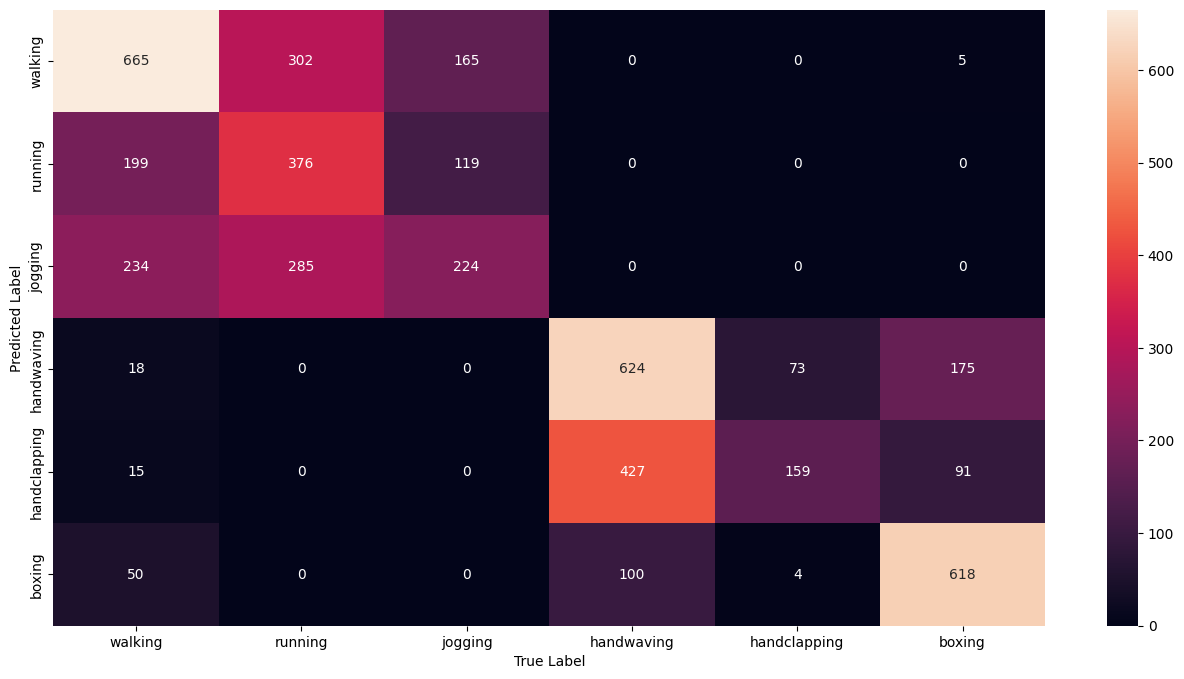

In [24]:
importlib.reload(utils)
utils.plot_confusion(lstm_cell_conf_matx, train_dataset.action_labels)

In [25]:
class GRUCellModel(nn.Module):

    def __init__(self, input_dim, conv_feature_maps, hidden_dim, n_layers, num_classes) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps
        input_channel, height, width = input_dim
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."

        # with maxpool input shape is divided by 2 
        self.encoder = nn.Sequential(
            network_samples.ConvBlock(input_channel, conv_feature_maps[0], kernel_size=3, pool=True, batchNorm=True),
            network_samples.ConvBlock(conv_feature_maps[0], conv_feature_maps[1], kernel_size=3, pool=True, batchNorm=True)
        )

        # compute new input dim
        new_input_dim = int(height//4 * width//4 * conv_feature_maps[1])

        # GRU model       
        grus = []
        for i in range(n_layers):
            in_size = new_input_dim if i == 0 else hidden_dim
            grus.append(nn.GRUCell(input_size=in_size, hidden_size=hidden_dim) )
        self.gru = nn.ModuleList(grus)
        # changed from taking only the last layer as input for the fc to all layers and outputs, seems to work better
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        batch_size, time_seq, height, width = x.shape

        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.n_layers)]
        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for LSTM with B x T_seq x all
        x_conv = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps[1] * height//4 * width//4)
 
        # iterating over sequence length
        gru_out = []
        for i in range(x_conv.shape[1]):
            gru_input = x_conv[:, i, :]
            # iterating over gru Cells
            for j, gru_cell in enumerate(self.gru):
                h[j] = gru_cell(gru_input, h[j])
                gru_input = h[j]
            gru_out.append(gru_input)
        gru_out = torch.stack(gru_out, dim=1)

        # only take last gru output
        out = self.fc(gru_out[:, -1, :])

        return out

In [26]:
input_dim = [1, 64, 64]
conv_feature_maps = [16, 16]
hidden_dim_gru = 128
n_layers = 8
gru_cell_model = GRUCellModel(input_dim=input_dim, hidden_dim=hidden_dim_gru, n_layers=n_layers, 
    conv_feature_maps=conv_feature_maps, num_classes=NUM_LABELS
    )
criterion = nn.CrossEntropyLoss()
gru_cell_optimizer = torch.optim.Adam(gru_cell_model.parameters(), lr=LR)
gru_cell_scheduler = torch.optim.lr_scheduler.StepLR(gru_cell_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(gru_cell_model)

2319606

In [27]:
importlib.reload(train_eval)
gru_cell_model = gru_cell_model.to(DEVICE)
gru_cell_tboard = utils.make_tboard_logs("simple_gru_cell")
gru_cell_train_loss, gru_cell_val_loss, gru_cell_loss_iters, gru_cell_valid_acc, gru_cell_conf_matx = train_eval.train_model(
    model=gru_cell_model, optimizer=gru_cell_optimizer, scheduler=gru_cell_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=gru_cell_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/schwemme/CudaLab_SGR_PS/Session04/tboard_logs/simple_gru_cell


Epoch 25 Iter 142: mean loss 0.26165. : 100%|██████████| 142/142 [00:24<00:00,  5.70it/s]

Training completed after 13.40min


#### **Task 1**
 - Implement a Convolutional LSTM (ConvLSTM() and/or ConvLSTMCell()) from scratch



In [7]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dims, hidden_dim, kernel_size) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        input_dim, self.height, self.width = input_dims
        self.kernel = kernel_size
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)

        # from the paper of ConvLSTM:
        # init the convolutions and tensors we need for the equations, zero padding according to paper
        # i_t input gate
        self.W_x_i = nn.Conv2d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_h_i = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_c_i = nn.Parameter(torch.zeros(1, hidden_dim, self.height, self.width))
        self.b_i = nn.Parameter(torch.zeros(1, 1, self.height, self.width))

        # f_t forget gate, basically the same structure as input gate
        self.W_x_f = nn.Conv2d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_h_f = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_c_f = nn.Parameter(torch.zeros(1, hidden_dim, self.height, self.width))
        self.b_f = nn.Parameter(torch.zeros(1, 1, self.height, self.width))

        # c_t update gate, different structure
        self.W_x_c = nn.Conv2d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_h_c = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.b_c = nn.Parameter(torch.zeros(1, 1, self.height, self.width))

        # o_t output gate
        self.W_x_o = nn.Conv2d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_h_o = nn.Conv2d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=(self.kernel), padding=self.padding)
        self.W_c_o = nn.Parameter(torch.zeros(1, hidden_dim, self.height, self.width))
        self.b_o = nn.Parameter(torch.zeros(1, 1, self.height, self.width))

    # in case we have a new sequence, reset the internal hidden states
    def reset_cell(self):
        self.W_c_i = nn.Parameter(torch.zeros(1, self.hidden_dim, self.height, self.width))
        self.W_c_f = nn.Parameter(torch.zeros(1, self.hidden_dim, self.height, self.width))
        self.W_c_o = nn.Parameter(torch.zeros(1, self.hidden_dim, self.height, self.width))

    def forward(self, x, h, c):
        # x = x_t, h = h_t-1, c = c_t-1
        # input gate computation
        i_t = torch.sigmoid(self.W_x_i(x) + self.W_h_i(h) + self.W_c_i * c + self.b_i)
        # forget gate computation
        f_t = torch.sigmoid(self.W_x_f(x) + self.W_h_f(h) + self.W_c_f + c + self.b_f)
        # update gate computation
        c_t = f_t * c + i_t * torch.tanh(self.W_x_c(x) + self.W_h_c(h) + self.b_c)
        # output gate
        o_t = torch.sigmoid(self.W_x_o(x) + self.W_h_o(x) + self.W_c_o * c + self.b_o)
        # new hidden state
        h_t = o_t * torch.tanh(c)
        return h_t, c_t

class ConvLSTM(nn.Module):
    # sets up a model
    def __init__(self, input_dims, conv_feature_maps, hidden_dim, n_layers, kernel, num_classes, mode="zeros") -> None:
        super().__init__()
        self.input_dims = input_dims
        self.hidden_dim = hidden_dim
        self.mode = mode
        self.n_layers = n_layers
        self.conv_feature_maps = conv_feature_maps

        input_channel, height, width = input_dims
        assert (height % 2) == 0 and (width % 2) == 0, "Ensure the input dimension is even numbered."

        # with maxpool input shape is divided by 2 
        self.encoder = network_samples.ConvBlock(input_channel, conv_feature_maps, kernel_size=3, pool=False)

        # compute new input dim if pool is not false
        # height = height // 2
        # width = width // 2

        layers = []
        for i in range(n_layers):
            in_size = [conv_feature_maps, height, width] if i == 0 else [hidden_dim, height, width]
            layers.append(ConvLSTMCell(input_dims=in_size, hidden_dim=hidden_dim, kernel_size=kernel))
        self.lstm = nn.ModuleList(layers)

        # set up a classifier for the task
        self.classifier = nn.Linear(in_features=hidden_dim * height * width, out_features=num_classes)

    def forward(self, x):
        """ Forward pass through model """
        
        # shape is batch, time, channel, img self.height, img width
        batch_size, time_seq, height, width = x.shape
        
        # pass through encoder, adjust dims to forward through conv layer
        x_reshaped = x.reshape(-1, height, width).unsqueeze(dim=1)
        x_conv_reshape = self.encoder(x_reshaped)
        # flatten for LSTM with B x T_seq x all
        x_conv = x_conv_reshape.reshape(batch_size, time_seq, self.conv_feature_maps, height, width)
        
        h, c = self.init_state(batch_size=batch_size, device=x.device) 
        # iterating over sequence length
        lstm_out = []
        for i in range(x_conv.shape[1]):
            lstm_input = x_conv[:, i, :, :, :]
            # iterating over LSTM Cells
            for j, lstm_cell in enumerate(self.lstm):
                h[j], c[j] = lstm_cell(lstm_input, h[j], c[j])
                lstm_input = h[j]
            lstm_out.append(lstm_input)
        lstm_out = torch.stack(lstm_out, dim=1)
            
        # classifying
        lstm_out = lstm_out.view(batch_size, seq_size, -1)
        y = self.classifier(lstm_out[:, -1, :])  # feeding only output at last layer
        return y
        
    def init_state(self, batch_size, device):
        """ Initializing hidden and cell state """
        if(self.mode == "zeros"):
            h = [torch.zeros(batch_size, self.hidden_dim, self.input_dims[1], self.input_dims[2]).to(device) for _ in range(self.n_layers)]
            c = [torch.zeros(batch_size, self.hidden_dim, self.input_dims[1], self.input_dims[2]).to(device) for _ in range(self.n_layers)]
        elif(self.mode == "random"):
            h = [torch.zeros(batch_size, self.hidden_dim, self.input_dims[1], self.input_dims[2]).to(device) for _ in range(self.n_layers)]
            c = [torch.zeros(batch_size, self.hidden_dim, self.input_dims[1], self.input_dims[2]).to(device) for _ in range(self.n_layers)]
        return h, c

    def reset_cells(self):
        # resets all ConvLSTM cells independently
        for c in self.lstm:
            c.reset_cell()


In [8]:
input_dim = [1, 64, 64]
conv_feature_maps = 16
hidden_dim_convlstm = 16
n_layers = 3
kernel=[3, 3]
convlstm_model = ConvLSTM(
    input_dims=input_dim, hidden_dim=hidden_dim_convlstm, conv_feature_maps=conv_feature_maps,
    n_layers=n_layers, kernel=kernel, num_classes=NUM_LABELS
    )
criterion = nn.CrossEntropyLoss()
convlstm_optimizer = torch.optim.Adam(convlstm_model.parameters(), lr=LR)
convlstm_scheduler = torch.optim.lr_scheduler.StepLR(convlstm_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(convlstm_model)

1088038

In [9]:
importlib.reload(train_eval)
convlstm_model = convlstm_model.to(DEVICE)
convlstm_tboard = utils.make_tboard_logs("simple_convlstm")
convlstm_train_loss, convlstm_val_loss, convlstm_loss_iters, convlstm_valid_acc, convlstm_conf_matx = train_eval.train_model(
    model=convlstm_model, optimizer=convlstm_optimizer, scheduler=convlstm_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=convlstm_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/schwemme/CudaLab_SGR_PS/Session04/tboard_logs/simple_convlstm


Epoch 25 Iter 142: mean loss 0.00263. : 100%|██████████| 142/142 [05:00<00:00,  2.11s/it]

Training completed after 147.77min


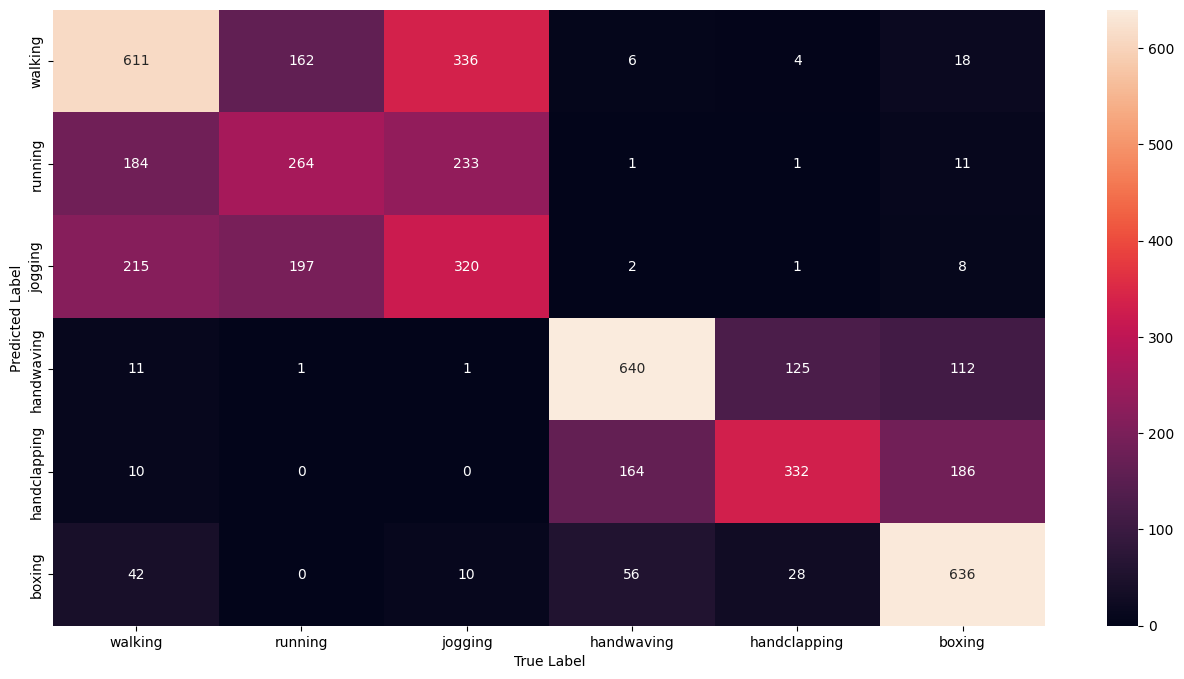

In [10]:
importlib.reload(utils)
utils.plot_confusion(convlstm_conf_matx, train_dataset.action_labels)

As we can see the ConvLSTM had 60.47% accuracy after 3 epochs, but also has the same training time as the other models with same 3 epochs (15 mins). Afterwards it is only overfitting, thus the accuracy decreases to 57%.

GRUCell and LSTMCell have the exact same parameters as the GRU and LSTM models given by pytorch, but the accuracy is different, and even worse (58% LSTM, 54% LSTMCel; 64% GRU, 61.5% GRUCell). We can only think of the seed being the reason why the models differ in such way. Of course it might be possible that Pytorch has some smart solution and more optimised ways than in our implementation s.t. it gets a better score.

All in all the task is fairly hard with only 20 frames, with respect that walking jogging and running are very similar, hence many false positives and false negatives in those 3 categories. Even for a human only 20 frames could be very hard to distinguish. With respect that the other three categories are better we have boxing, handwaving, handclapping where you can get roughly 50% accuracy if all done right, and then just 16% random guessing if the prediction is in the movement category. Therefore the results are reasonable.

#### **Extra Point**
  - Implement a 3D-CNN for action classification on the KTH-Actions dataset
  - Compare it with the RNN-based models

In [85]:
class Conv3DBlock(nn.Module):

    def __init__(self, input_dim, output_dim, kernel, act_fn=nn.ReLU(), pool=False, batchnorm=False) -> None:
        super().__init__()
        
        layers = []
        layers.append(nn.Conv3d(
            in_channels=input_dim, out_channels=output_dim, kernel_size=kernel, padding=kernel//2
            ))
        if batchnorm == True:
            layers.append(nn.BatchNorm3d(output_dim))
        layers.append(act_fn)
        if pool == True:
            layers.append(nn.MaxPool3d(kernel_size=2))
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)

class CNN3D(nn.Module):

    def __init__(self, input_dims,  hidden_dims, kernel, num_classes, pool=True, batchnorm=True) -> None:
        super().__init__()
        self.hidden_dims = hidden_dims
        depth, height, width = input_dims[1], input_dims[2], input_dim[3]
        
        cnns = []
        for i in range(len(hidden_dims)):
            height = height//2
            width = width//2
            depth = depth//2
            if i == 0:
                cnns.append(Conv3DBlock(input_dim=input_dims[0], output_dim=hidden_dims[0], kernel=kernel, pool=pool, batchnorm=batchnorm))
            else:
                cnns.append(Conv3DBlock(input_dim=hidden_dims[i-1], output_dim=hidden_dims[i], kernel=kernel, pool=pool, batchnorm=batchnorm))
        self.convs = nn.Sequential(*cnns)
        # linear layer has to take depth into account as well
        self.fc = nn.Linear(in_features= depth * height * width * hidden_dims[-1], out_features=num_classes)
    
    def forward(self, x):
        # shape is batch, time, channel, img self.height, img width
        batch_size, time_seq, height, width = x.shape
        # x needs to be: batch, channel, D, W, H
        x = x.unsqueeze(dim=1)

        x_conv = self.convs(x)
        x_conv = x_conv.view(batch_size, -1)
        out = self.fc(x_conv)
        return out
        

In [86]:
input_dim = [1, 20, 64, 64]
hidden_dim_cnn3d = [8, 16, 32, 64]
kernel=torch.tensor([3, 3, 3])
cnn3d_model = CNN3D(
    input_dims=input_dim, hidden_dims=hidden_dim_cnn3d, kernel=kernel, num_classes=NUM_LABELS
    )
criterion = nn.CrossEntropyLoss()
cnn3d_optimizer = torch.optim.Adam(cnn3d_model.parameters(), lr=LR)
cnn3d_scheduler = torch.optim.lr_scheduler.StepLR(cnn3d_optimizer, step_size=5, gamma=0.5)
utils.count_parameters(cnn3d_model)

79302

In [87]:
importlib.reload(train_eval)
cnn3d_model = cnn3d_model.to(DEVICE)
cnn3d_tboard = utils.make_tboard_logs("simple_cnn3d")
cnn3d_train_loss, cnn3d_val_loss, cnn3d_loss_iters, cnn3d_valid_acc, cnn3d_conf_matx = train_eval.train_model(
    model=cnn3d_model, optimizer=cnn3d_optimizer, scheduler=cnn3d_scheduler, 
    criterion=criterion, train_loader=train_loader, valid_loader=test_loader, 
    num_epochs=NUM_EPOCHS, device=DEVICE, tboard=cnn3d_tboard, 
    all_labels=train_dataset.action_labels)

/home/user/schwemme/CudaLab_SGR_PS/Session04/tboard_logs/simple_cnn3d


Epoch 25 Iter 142: mean loss 0.17029. : 100%|██████████| 142/142 [00:27<00:00,  5.24it/s]

Training completed after 11.69min


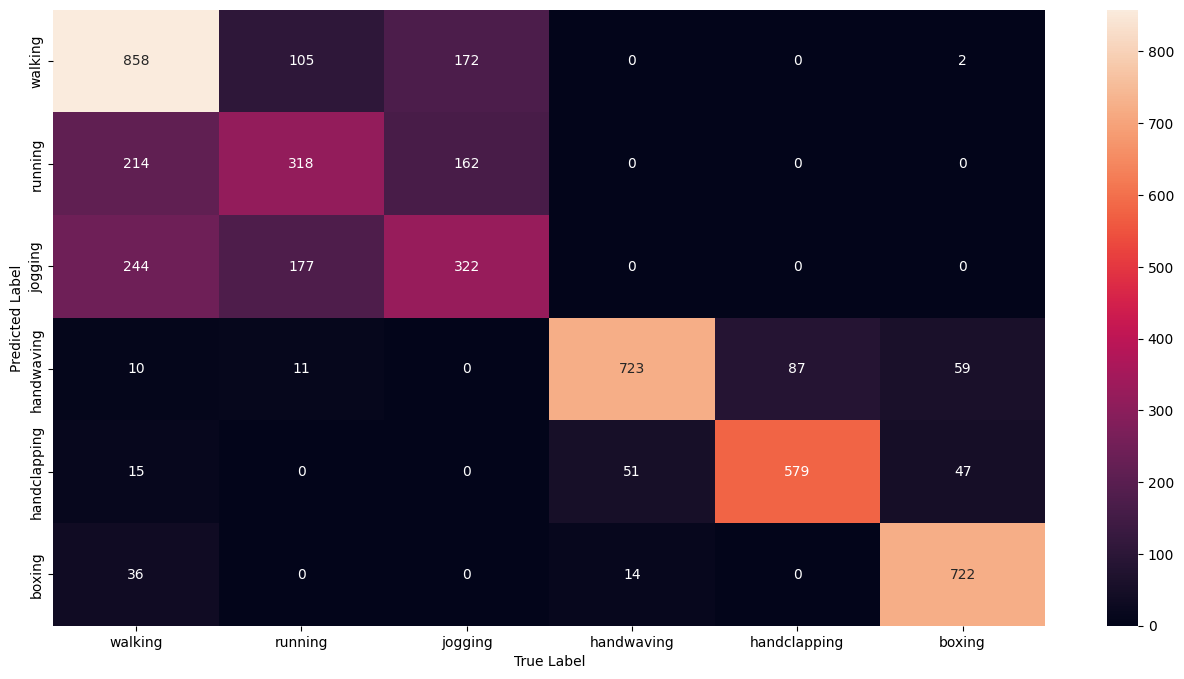

In [88]:
utils.plot_confusion(cnn3d_conf_matx, train_dataset.action_labels)

With an Accuracy of 72.52% the CNN3D outperforms every other method with less parameters by a very large amount (a bit mit thatn 8% of the previous best beimg GRU). What stands out the most is a very clear seperation of handwaving, handclapping and boxing.